In [1]:
# Main libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Natural Language Libraries
import re 

## Spacy ##
import spacy
import spacy_lookups_data
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

## sklearn ##
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# ML Models


### Load Dataset

In [2]:
data = pd.read_csv('data/fake_job_postings.csv')
print(data.shape)
data.head()

(17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Subsetting the text part of the DataFrame

In [3]:
### Separate the text columns into two

text = data[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent']].fillna('')

text['company'] = text[['company_profile', 'description']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
text['offer'] = text[['title', 'requirements', 'benefits']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

text.drop(['title', 'company_profile', 'description', 'requirements', 'benefits'], axis=1, inplace=True)
text.head()

,fraudulent,company,offer
0,0,"We're Food52, and we've created a groundbreaki...",Marketing InternExperience with content manage...
1,0,"90 Seconds, the worlds Cloud Video Production ...",Customer Service - Cloud Video ProductionWhat ...
2,0,Valor Services provides Workforce Solutions th...,Commissioning Machinery Assistant (CMA)Impleme...
3,0,Our passion for improving quality of life thro...,Account Executive - Washington DCEDUCATION: Ba...
4,0,SpotSource Solutions LLC is a Global Human Cap...,Bill Review ManagerQUALIFICATIONS:RN license i...


In [4]:
# Split the dataset (text) into fraudulent or not

text_fraudulent = text[text['fraudulent'] == 1]
text_not_fraudulent = text[text['fraudulent'] == 0]

In [5]:
## FAST EDA of main Words for text-fraudulent / no and column description
'''
columns = [text_fraudulent["company"], text_fraudulent['offer'], text_not_fraudulent['company'], text_not_fraudulent['offer']] 
for column in columns:
    str_bow_raw = ' '.join([' '.join(column.astype(str).tolist())])
    wordcloud = WordCloud(width=480, height=480, margin=0).generate(str_bow_raw)
 
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
'''

'\ncolumns = [text_fraudulent["company"], text_fraudulent[\'offer\'], text_not_fraudulent[\'company\'], text_not_fraudulent[\'offer\']] \nfor column in columns:\n    str_bow_raw = \' \'.join([\' \'.join(column.astype(str).tolist())])\n    wordcloud = WordCloud(width=480, height=480, margin=0).generate(str_bow_raw)\n \n    # Display the generated image:\n    plt.imshow(wordcloud, interpolation=\'bilinear\')\n    plt.axis("off")\n    plt.margins(x=0, y=0)\n    plt.show()\n'

## Text Cleaning

In [6]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser']) 
nlp.max_length = 15000000

In [7]:
### Clean company (columns: 'company_profile', 'description')
# Lower and Urls clean
def clean_urls(column):
    '''
    This functions takes an string and returns an string 
    with the url removed and the words in lower case.
    '''
    return column.apply(lambda x: x.lower()).apply(lambda x: re.sub('http[s]?://\S+', '', x))
    
text['company'] = text['company'].apply(lambda x: x.lower())
text['company'] = text['company'].apply(lambda x: re.sub('http[s]?://\S+', '', x))
text['company'].head(3)

0    we're food52, and we've created a groundbreaki...
1    90 seconds, the worlds cloud video production ...
2    valor services provides workforce solutions th...
Name: company, dtype: object

In [8]:
def string_to_lemma(string):
    '''
    This function takes a sentence and returns the list of all lemma
    '''
    doc = nlp(string)
    l_token = [token.lemma_ for token in doc if not token.is_punct 
               | token.is_space | token.is_stop | token.is_digit & token.is_oov] 
    #singular_token = [token for token in nlp(l_token) if token.tag_ == 'NNPS' | token.tag_ == 'NNS']
    return ' '.join(l_token)
    

In [9]:
### High Memory consumption ###

text['company'] = text['company'].apply(lambda row: string_to_lemma(row))

### Clean offer columns ('title', 'requirements', 'benefits')

In [19]:
text['offer'] = text['offer'].apply(lambda x: x.lower())
text['offer'] = text['offer'].apply(lambda x: re.sub('http[s]?://\S+', '', x))
text['offer'] = text['offer'].apply(lambda row: string_to_lemma(row))

## TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf_company = TfidfVectorizer().fit_transform(text['company'])
tfidf_offer = TfidfVectorizer().fit_transform(text['offer'])


In [24]:
print(tfidf_company.shape)
print(tfidf_offer.shape)

(17880, 62561)
(17880, 64119)


## Sparce PCA

In order to reduce the amount of words for ML algorithms it is necessary to perform a reduction of dimensions in the matrices. Therefore and according to the data that we have (with lots of 0) a Sparce PCA was performed.

In [40]:
#### MEMORY ERROR ###

## Alternativa MiniBatchSparsePCA

from sklearn.decomposition import SparsePCA

transformer = SparsePCA(n_components=50, random_state=42)
transformer.fit(tfidf_company[0:1000].toarray())
company_transformed = transformer.transform(tfidf_company[0:1000].toarray()) ## Sin subset no hay que pasar el argumento .toarray()

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


In [41]:
company_transformed

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00050939,  0.01610009,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00762437,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00041759,  0.00230736,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00037271,  0.00998639,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [42]:
#### MEMORY ERROR ###

transformer.fit(tfidf_offer[0:1000].toarray())
offer_transformed = transformer.transform(tfidf_offer[0:1000].toarray())

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


## Truncted SVD - TSNE

In [74]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD # Reducción de la dimensión

## Probar UMAP tb

In [116]:
# Hacer por separado
X = tfidf_company
X_offer = tfidf_offer

y = text['fraudulent']

tSVC = TruncatedSVD(n_components=50, random_state=42) 
# Probar de hacer un decission tree y visualizarlo --> Ensemble con numericas/categoricas
t = tSVC.fit(X).transform(X)
t_offer = tSVC.fit(X_offer).transform(X_offer)

#tsne = TSNE(n_components=2, random_state=42)
#X_tsne = tsne.fit_transform(t)

In [96]:
from sklearn.preprocessingprocessingprocessing import MinMaxScaler

In [129]:
minmax = MinMaxScaler()
minmax_t = minmax.fit_transform(t)
minmax_t_offer = minmax.fit_transform(t_offer)

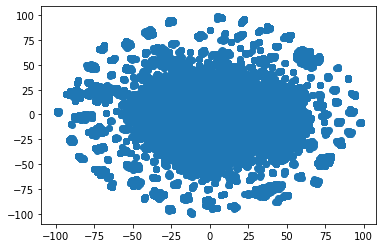

In [88]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], )

In [89]:
tsne_df = pd.DataFrame({'X':X_tsne[:,0], 'Y': X_tsne[:,1], 'class': y})

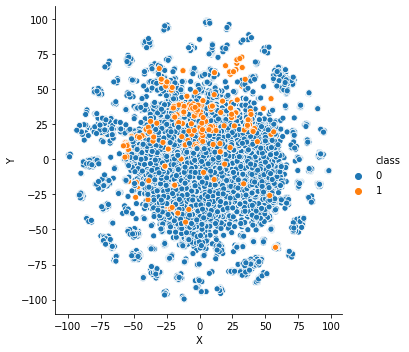

In [90]:
sns.relplot(data=tsne_df, x='X', y='Y', hue='class')

## ML Models

In [133]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

X = pd.concat([pd.DataFrame(tfidf_company), pd.DataFrame(tfidf_offer)], axis=1)
y = text['fraudulent']

Ramdom_sample = RandomUnderSampler(random_state=42)
X_rus, y_rus = Ramdom_sample.fit_resample(minmax_t, y)

In [137]:
Ramdom_sample = RandomUnderSampler(random_state=42)
X_rus_offer, y_rus_offer = Ramdom_sample.fit_resample(minmax_t_offer, y)

In [111]:
from sklearn.model_selection import train_test_split

#X = pd.concat([pd.DataFrame(company_transformed), pd.DataFrame(offer_transformed)], axis=1) 
## Al hacer el split con 1000 me da X must be non negative
#X = pd.concat([pd.DataFrame(tfidf_company), pd.DataFrame(tfidf_offer)], axis=1)
#y = text['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, stratify=y_rus, random_state=42)

In [138]:
X_train_offer, X_test_offer, y_train_offer, y_test_offer = train_test_split(X_rus_offer, y_rus_offer, test_size=0.2, stratify=y_rus, random_state=42)

In [171]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix

# Cambiar metodo del CrossValidation para incorporar Shuffle
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)
    #logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'specificity': [specificity]
                             #'logloss'      : [logloss]
                            })   # timetaken: to be used for comparison later
    return df_model

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier

In [172]:
models = {'gnb': GaussianNB(),
          'bnb': BernoulliNB(),
          'mnb': MultinomialNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'svc': SVC(probability=True),
          'linearsvc': LinearSVC(),
          'xgboost': GradientBoostingClassifier(),
          'NN': MLPClassifier()
         }

models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\log

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum

In [173]:
models_df

,model,accuracy,precision,recall,f1score,rocauc,specificity
0,gnb,0.732140,0.660638,0.940872,0.780440,0.811420,0.920455
0,bnb,0.499639,0.400000,0.800000,0.667310,0.500000,NaN
0,mnb,0.760279,0.750503,0.779251,0.761292,0.836495,0.820359
0,logit,0.799393,0.782263,0.832666,0.804303,0.882154,0.858974
0,knn,0.830983,0.794051,0.910531,0.845819,0.916513,0.898551
0,decisiontree,0.805062,0.797556,0.818225,0.832621,0.811547,0.832335
0,randomforest,0.852745,0.868409,0.844177,0.849034,0.923595,0.885542
0,svc,0.769644,0.779631,0.732968,0.762964,0.845794,0.830189
0,linearsvc,0.809408,0.778142,0.857106,0.819664,0.890971,0.870968
0,xgboost,0.864282,0.849006,0.883140,0.860764,0.934673,0.907975


In [174]:
models_df_offer = pd.concat([baseline_report(model, X_train_offer, X_test_offer, y_train_offer, y_test_offer, name) for (name, model) in models.items()])
models_df_offer

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum

,model,accuracy,precision,recall,f1score,rocauc,specificity
0,gnb,0.664921,0.615578,0.861433,0.720058,0.769952,0.790000
0,bnb,0.517687,1.000000,0.036075,0.069543,0.520853,0.510264
0,mnb,0.686564,0.712936,0.610406,0.655593,0.751806,0.659574
0,logit,0.736441,0.736421,0.741643,0.745542,0.811859,0.755814
0,knn,0.753814,0.736044,0.813867,0.779223,0.852861,0.801325
0,decisiontree,0.727753,0.710440,0.741779,0.726653,0.734919,0.683333
0,randomforest,0.771852,0.808683,0.760494,0.768696,0.859206,0.780749
0,svc,0.576888,0.957793,0.165989,0.272311,0.801375,0.550955
0,linearsvc,0.742183,0.728039,0.792201,0.759525,0.822487,0.832215
0,xgboost,0.804372,0.805724,0.825441,0.811052,0.882998,0.838509


In [115]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
multi_layer_perceptron = MLPClassifier(random_state =42).fit(X_train, y_train)
y_mlp_pred = multi_layer_perceptron.predict(X_test)
print(confusion_matrix(y_test, y_mlp_pred))
print(classification_report(y_test, y_mlp_pred))

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[139  35]
 [ 17 156]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       174
           1       0.82      0.90      0.86       173

    accuracy                           0.85       347
   macro avg       0.85      0.85      0.85       347
weighted avg       0.85      0.85      0.85       347



## ALL TEXT PROCESSING 

In [143]:
text_all = data[['title', 'company_profile', 'description', 'requirements', 'benefits', 'industry','fraudulent']].fillna('')
text_all['transcript'] = text_all[['title', 'requirements', 'benefits', 'company_profile', 'description', 'industry']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
text_all.drop(['title', 'requirements', 'benefits', 'company_profile', 'description', 'industry'], axis=1, inplace=True)
text_all.head()
              

,fraudulent,transcript
0,0,Marketing InternExperience with content manage...
1,0,Customer Service - Cloud Video ProductionWhat ...
2,0,Commissioning Machinery Assistant (CMA)Impleme...
3,0,Account Executive - Washington DCEDUCATION: Ba...
4,0,Bill Review ManagerQUALIFICATIONS:RN license i...


In [146]:
# Tarda un ratito...

text_all['transcript'] = text_all['transcript'].apply(lambda x: x.lower())
text_all['transcript'] = text_all['transcript'].apply(lambda x: re.sub('http[s]?://\S+', '', x))
text_all['transcript'] = text_all['transcript'].apply(lambda row: string_to_lemma(row))
text_all['transcript'].head(3)

0    marketing internexperience content management ...
1    customer service cloud video productionwhat ex...
2    commission machinery assistant cma)implement p...
Name: transcript, dtype: object

In [148]:
## TD-IDF

tfidf = TfidfVectorizer().fit_transform(text_all['transcript'])

In [150]:
## TruncatedSVD para reducir dimensiones

X = tfidf
y = text_all['fraudulent']

tSVC = TruncatedSVD(n_components=50, random_state=42)
t_all = tSVC.fit(X).transform(X)

In [151]:
## MinMax Scaler

minmax = MinMaxScaler()
minmax_all = minmax.fit_transform(t_all)

In [152]:
## UnderSampling --> Quizá debería usarse antes de limpiado de datos (justo despues del text_all.head())

Ramdom_sample = RandomUnderSampler(random_state=42)
X_rus_all, y_rus_all = Ramdom_sample.fit_resample(minmax_all, y)

In [175]:
## Split into train - test

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_rus_all, y_rus_all, test_size=0.2, stratify=y_rus, random_state=42)

models_df = pd.concat([baseline_report(model, X_train_all, X_test_all, y_train_all, y_test_all, name) for (name, model) in models.items()])

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum

In [177]:
models_df

,model,accuracy,precision,recall,f1score,rocauc,specificity
0,gnb,0.716201,0.661246,0.900407,0.759365,0.826809,0.857143
0,bnb,0.511911,1.000000,0.024523,0.047448,0.514367,0.507289
0,mnb,0.782627,0.793472,0.756073,0.785827,0.862187,0.814607
0,logit,0.806496,0.798236,0.829622,0.806075,0.886550,0.838323
0,knn,0.829617,0.797131,0.923585,0.857269,0.921214,0.911565
0,decisiontree,0.792048,0.789552,0.826879,0.800330,0.815181,0.807229
0,randomforest,0.844738,0.881876,0.828193,0.852793,0.922424,0.854839
0,svc,0.765333,0.856602,0.617631,0.723808,0.862494,0.836158
0,linearsvc,0.818080,0.792699,0.849891,0.816535,0.884472,0.850932
0,xgboost,0.862121,0.855137,0.886018,0.877679,0.941337,0.872093
